# Compare classifiers across consensus profiles

Compare classifier metrics across different consensus profile strategies, stratefied by representations types. We also compare all results to the random baseline. 

In [1]:
import polars as pl 
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import MultiComparison

## Input annotations

In [5]:
endpoint_types = ["toxcast_cellbased", "toxcast_cellfree", "toxcast_cytotox", "axiom"]

pred_df = []
for et in endpoint_types:
    preds = pl.read_parquet(f"../compiled_results/compiled_{et}_metrics.parquet")
    preds = preds.with_columns(
        (pl.col("Metadata_Count_0") + pl.col("Metadata_Count_1")).alias("Total_Compounds"),
        pl.lit(et).alias("Endpoint_type")
    )
    pred_df.append(preds)

pred_df = pl.concat(pred_df, how="vertical")
pred_df = pred_df.with_columns(
    pl.when(pl.col("Endpoint_type") == "axiom").then(pl.lit("axiom_cytotox")).otherwise(pl.col("Endpoint_type")).alias("Endpoint_type")
)

cpcnn = pred_df.filter(pl.col("Feat_type") == "cpcnn")
dino = pred_df.filter(pl.col("Feat_type") == "dino")
cellprofiler = pred_df.filter(pl.col("Feat_type") == "cellprofiler")

### CPCNN

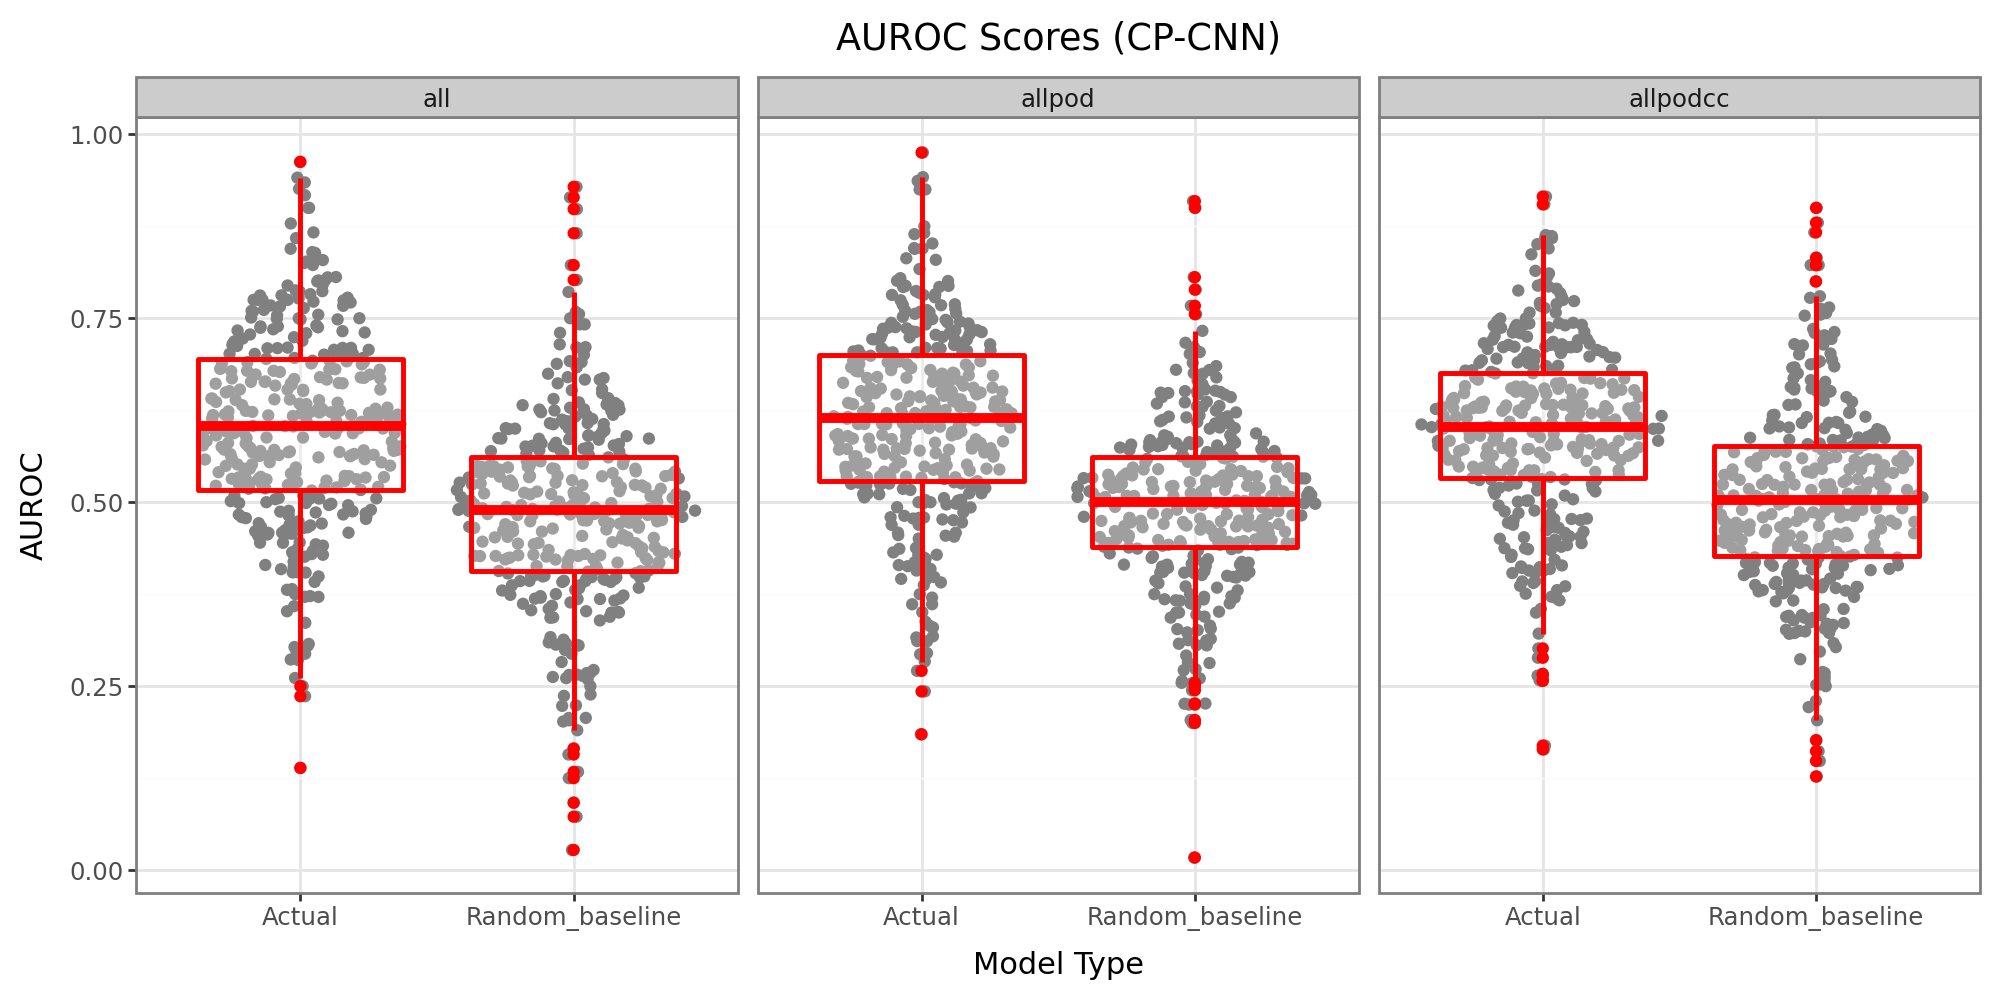

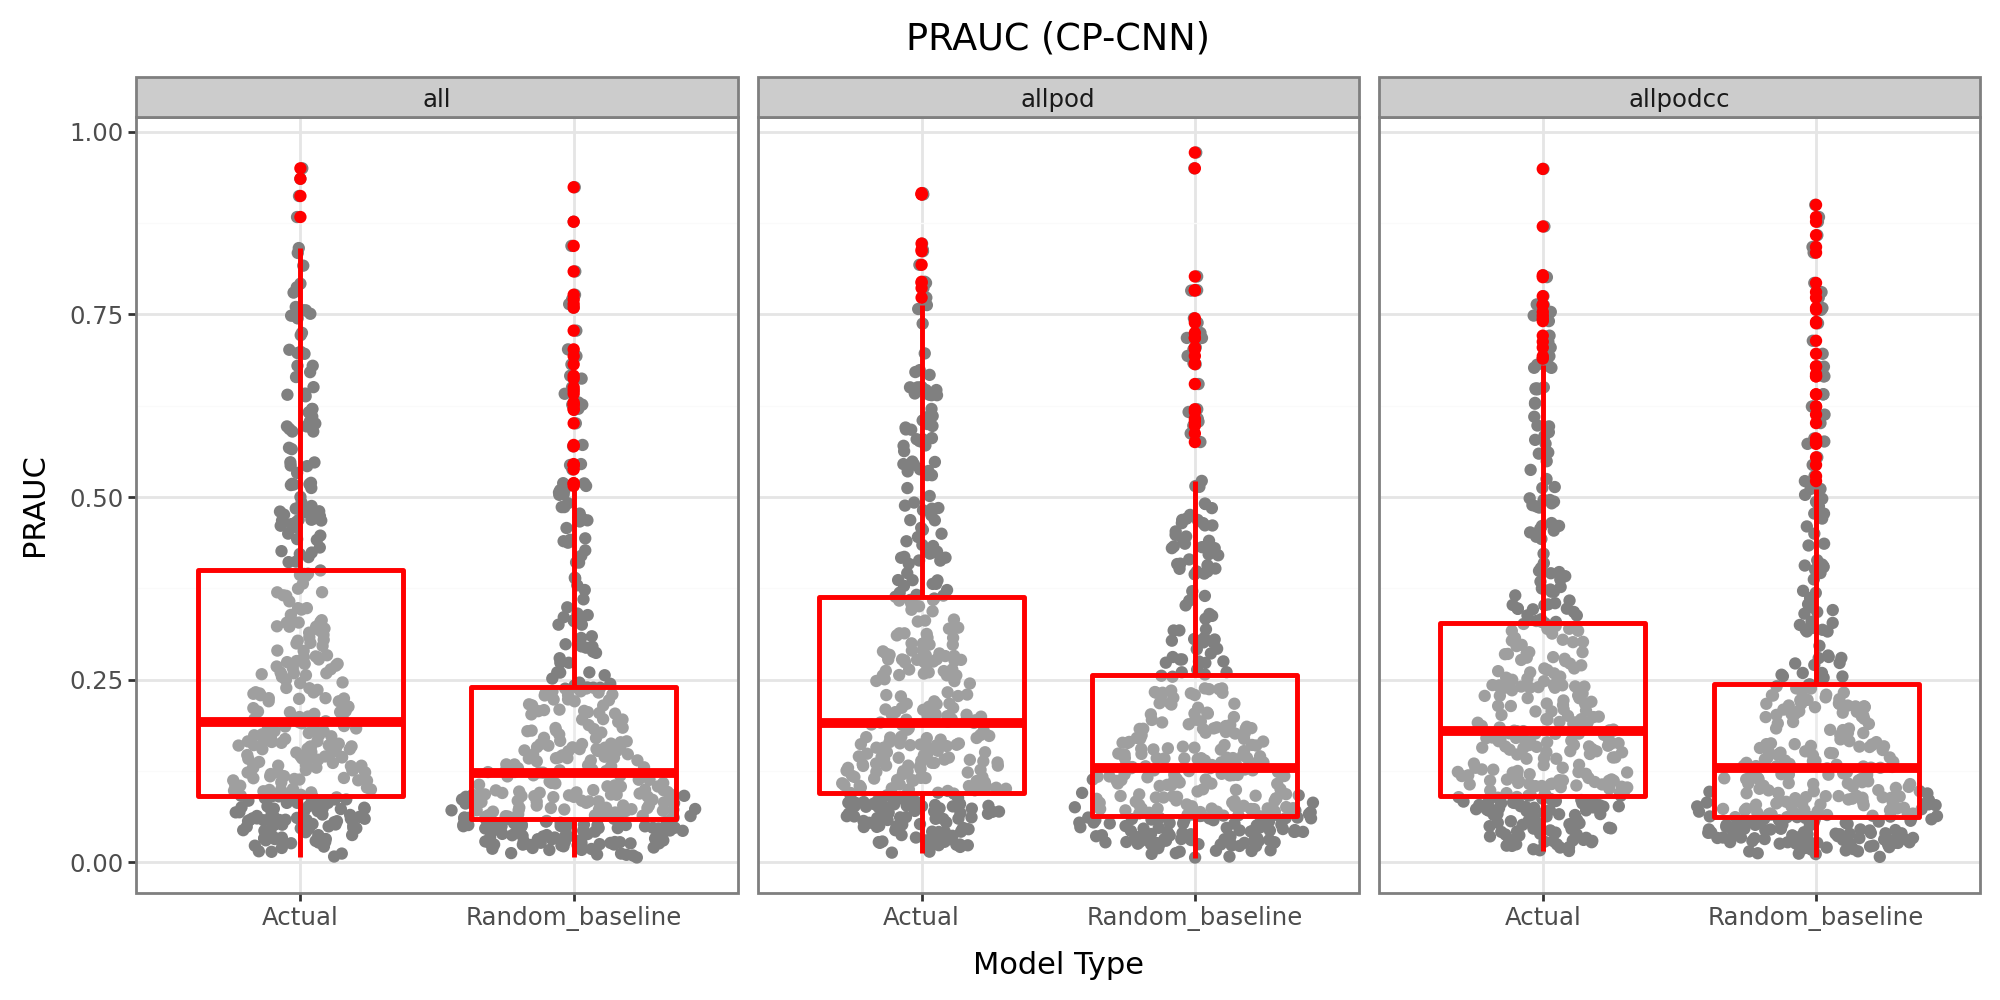

In [6]:
from plotnine import ggplot, aes, geom_sina, geom_boxplot, labs, theme_bw, position_dodge, facet_wrap
import plotnine as pn

pn.options.figure_size = (10, 5)

plot = (
    ggplot(cpcnn, aes(x='Model_type', y='AUROC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + facet_wrap("Metadata_AggType", ncol=5)
    + labs(title='AUROC Scores (CP-CNN)', x='Model Type', y='AUROC') 
    + theme_bw()
)
plot.show()

plot = (
    ggplot(cpcnn, aes(x='Model_type', y='PRAUC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + facet_wrap("Metadata_AggType", ncol=5)
    + labs(title='PRAUC (CP-CNN)', x='Model Type', y='PRAUC') 
    + theme_bw()
)
plot.show()

### Dino

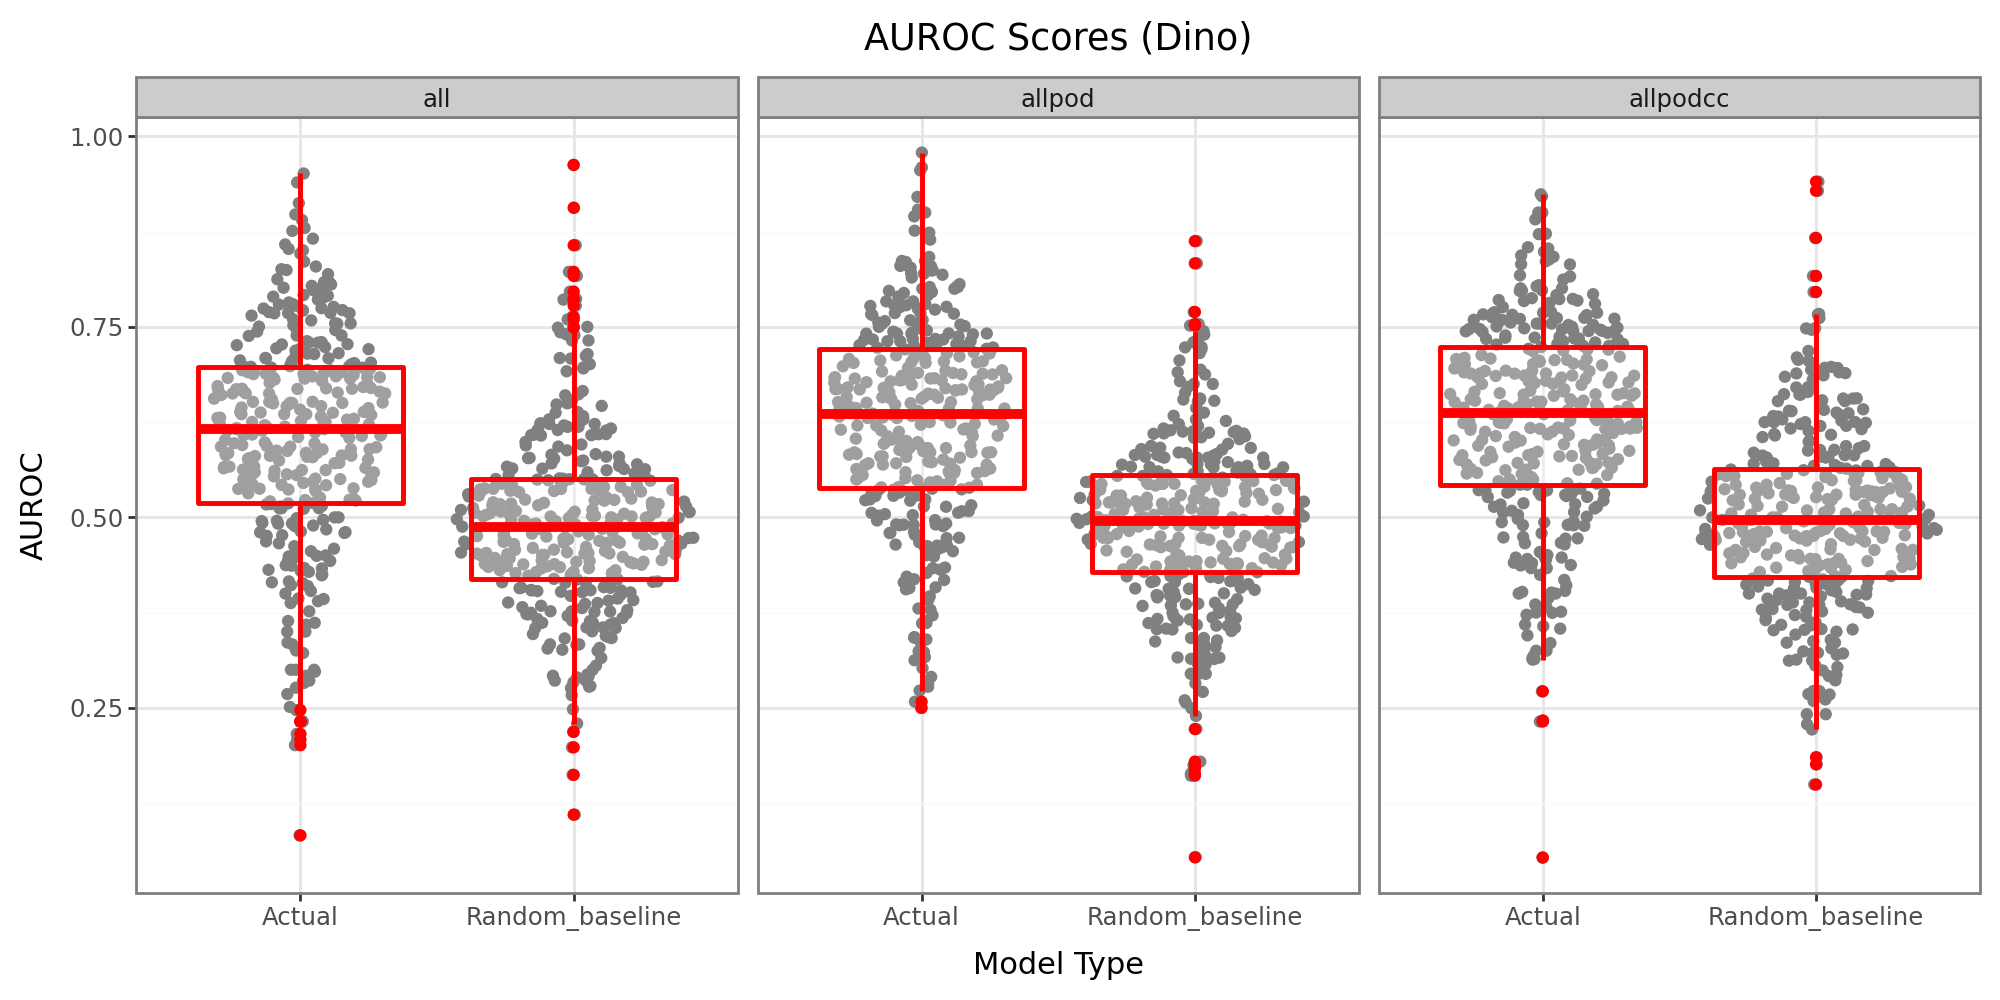

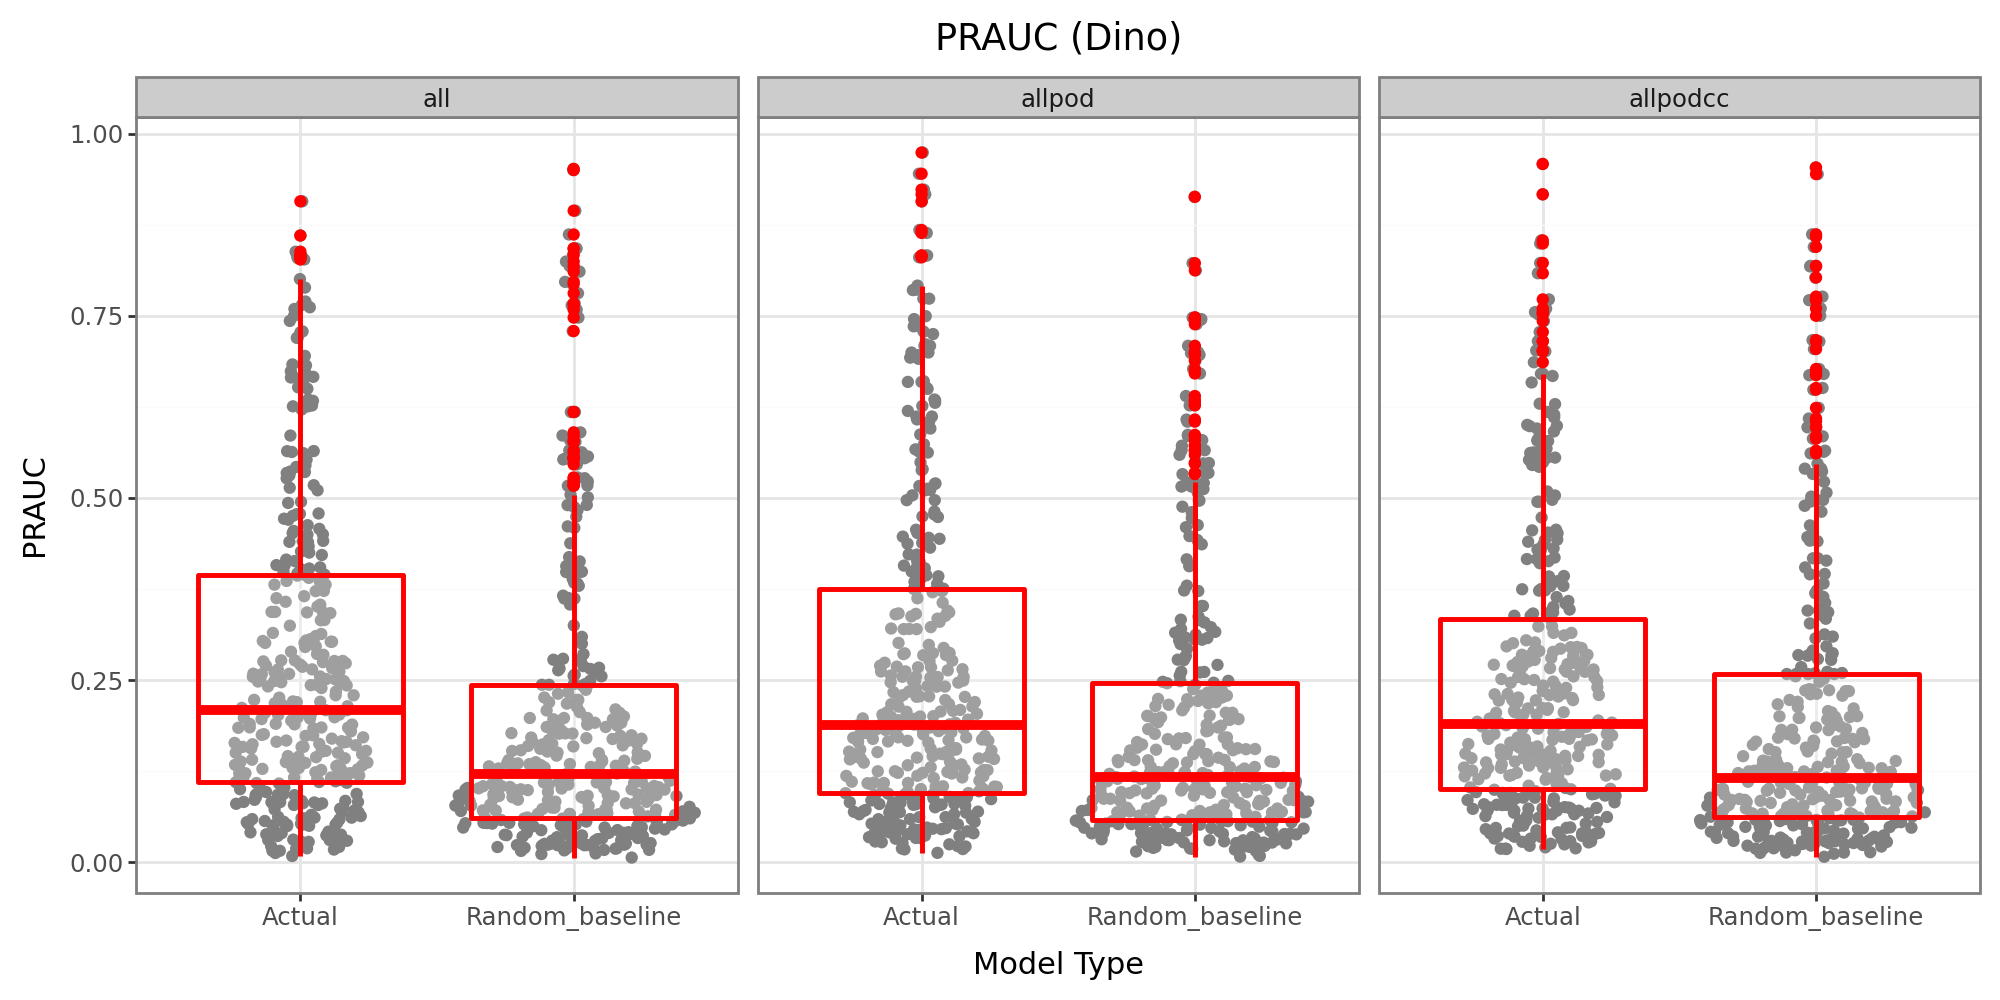

In [7]:
from plotnine import ggplot, aes, geom_sina, geom_boxplot, labs, theme_bw, position_dodge, facet_wrap
import plotnine as pn

pn.options.figure_size = (10, 5)

plot = (
    ggplot(dino, aes(x='Model_type', y='AUROC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + facet_wrap("Metadata_AggType", ncol=5)
    + labs(title='AUROC Scores (Dino)', x='Model Type', y='AUROC') 
    + theme_bw()
)
plot.show()

plot = (
    ggplot(dino, aes(x='Model_type', y='PRAUC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + facet_wrap("Metadata_AggType", ncol=5)
    + labs(title='PRAUC (Dino)', x='Model Type', y='PRAUC') 
    + theme_bw()
)
plot.show()

### CellProfiler

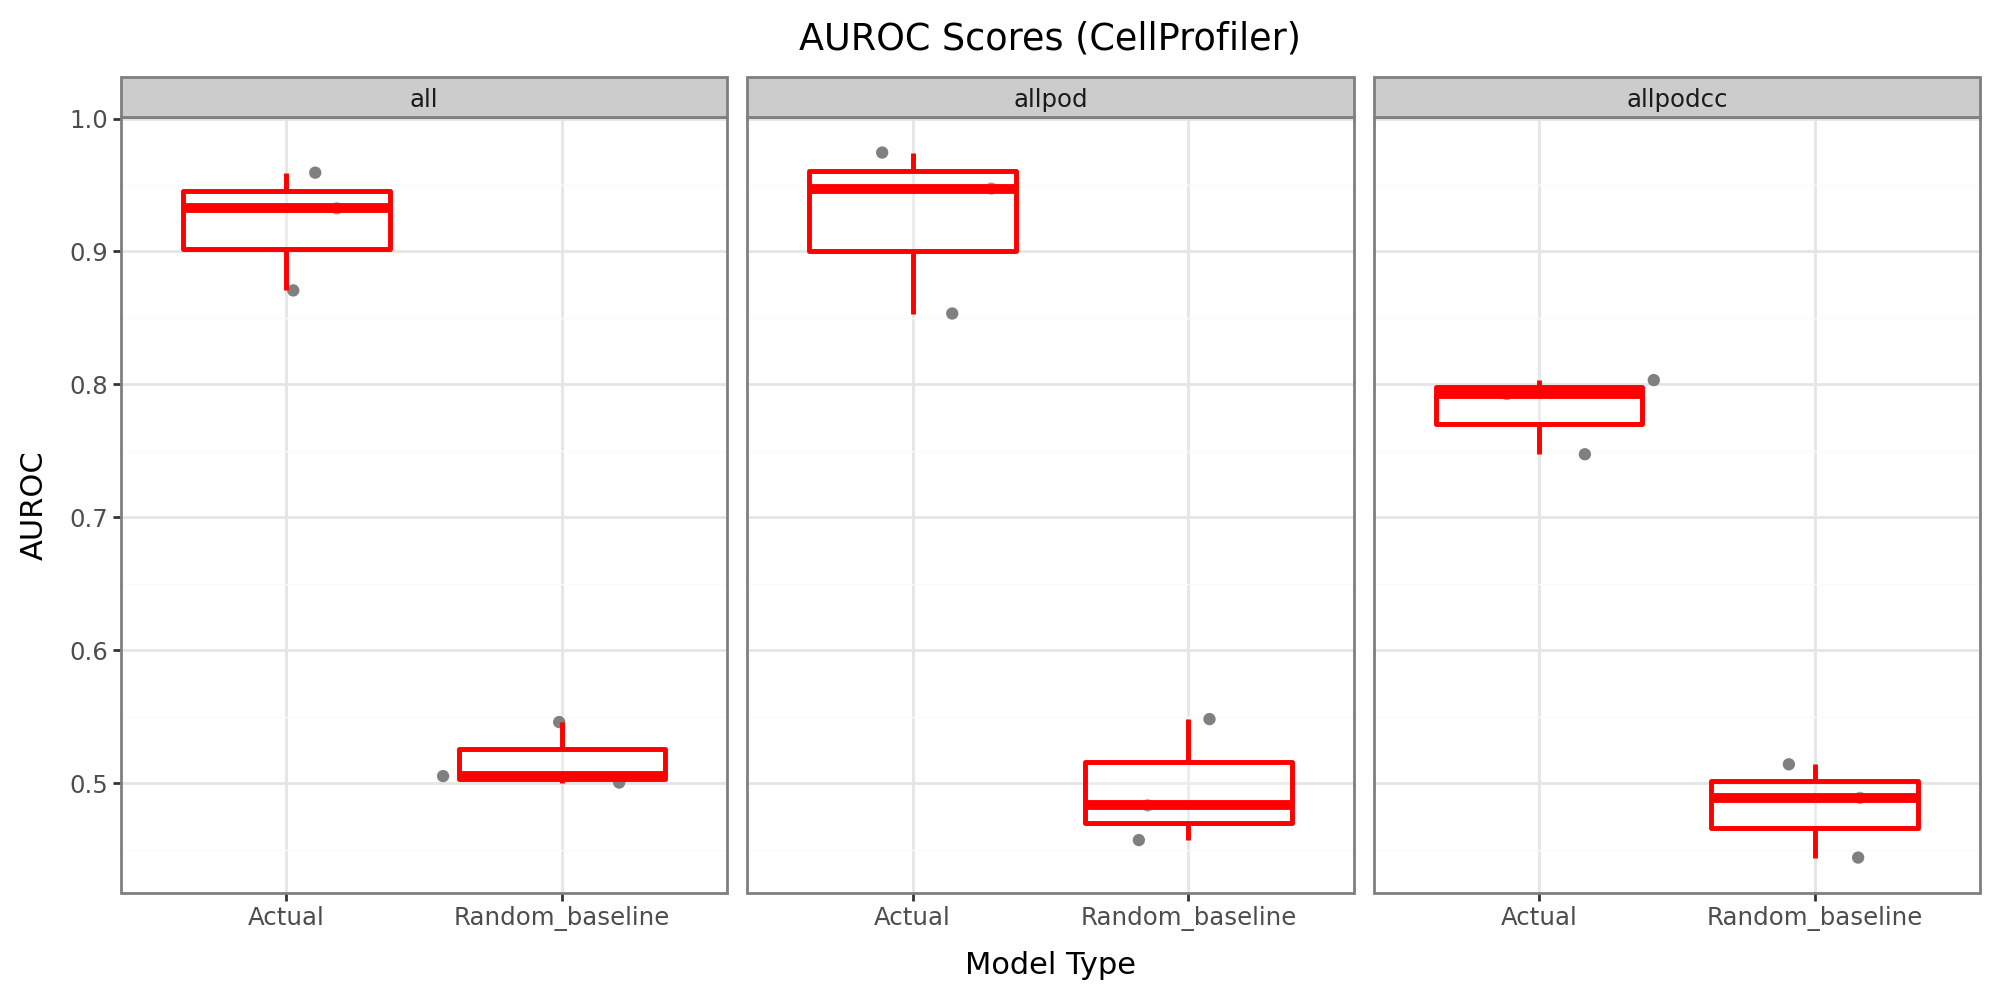

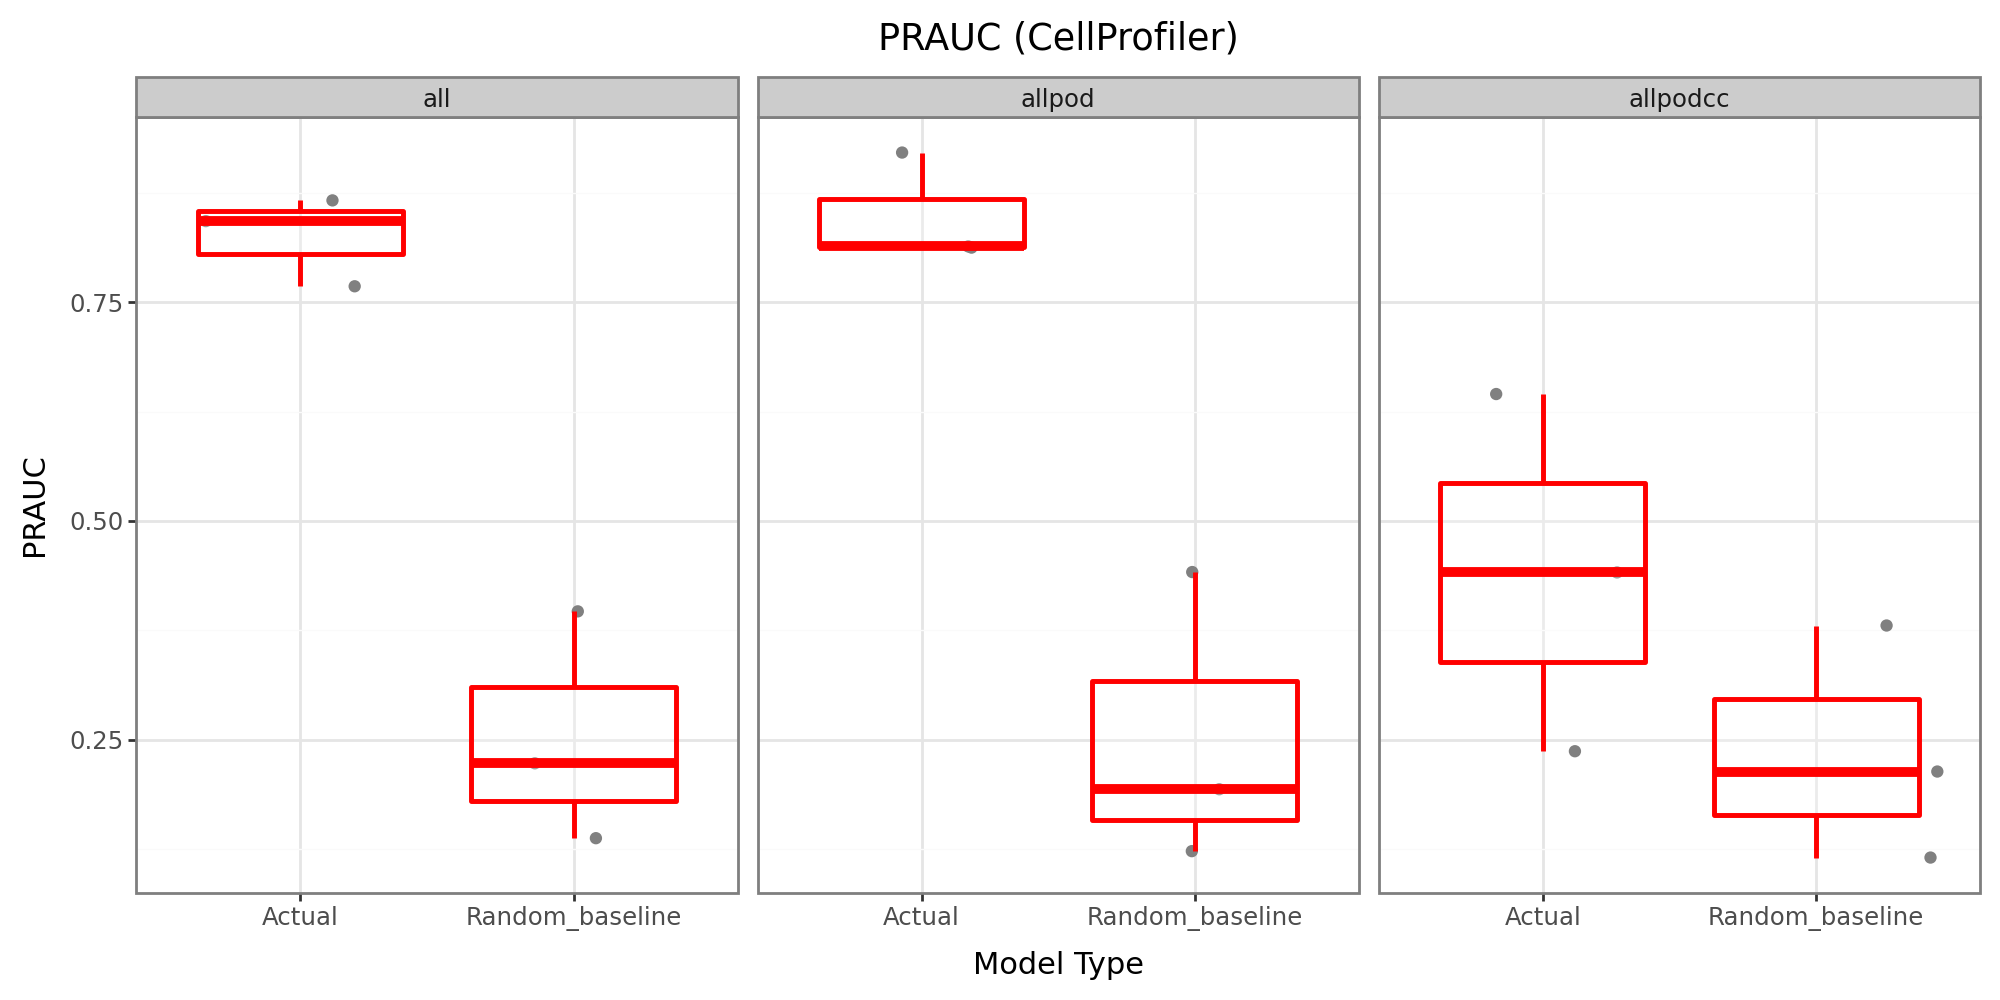

In [46]:
from plotnine import ggplot, aes, geom_sina, geom_boxplot, labs, theme_bw, position_dodge, facet_wrap
import plotnine as pn

pn.options.figure_size = (10, 5)

plot = (
    ggplot(cellprofiler, aes(x='Model_type', y='AUROC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + facet_wrap("Metadata_AggType", ncol=5)
    + labs(title='AUROC Scores (CellProfiler)', x='Model Type', y='AUROC') 
    + theme_bw()
)
plot.show()

plot = (
    ggplot(cellprofiler, aes(x='Model_type', y='PRAUC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + facet_wrap("Metadata_AggType", ncol=5)
    + labs(title='PRAUC (CellProfiler)', x='Model Type', y='PRAUC') 
    + theme_bw()
)
plot.show()

## Compute statistics

Right now we are just comparing across AggType for all representations and without separating out the null. We really want to know if there are statistically significant differences in how different concentrations perform, relative to their matched null.

In [47]:
# First, compare to baseline
pandas = preds.to_pandas()

In [48]:
model = smf.mixedlm("AUROC ~ Model_type", pandas, groups=pandas["Metadata_Label"],
                    re_formula="~Feat_type+Metadata_AggType")
result = model.fit()
pandas["fitted_values"] = result.fittedvalues

mc = MultiComparison(pandas["fitted_values"], pandas["Model_type"])
tukey_result = mc.tukeyhsd()

tukey_pvals = tukey_result.pvalues
print(tukey_result.summary())
print(tukey_pvals)

/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/dgx1nas1/storage/data/jes

    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1      group2     meandiff p-adj  lower   upper  reject
------------------------------------------------------------
Actual Random_baseline  -0.3924   0.0 -0.4064 -0.3784   True
------------------------------------------------------------
[6.99440506e-15]


In [49]:
model = smf.mixedlm("PRAUC ~ Model_type", pandas, groups=pandas["Metadata_Label"],
                    re_formula="~Feat_type+Metadata_AggType")
result = model.fit()
pandas["fitted_values"] = result.fittedvalues

mc = MultiComparison(pandas["fitted_values"], pandas["Model_type"])
tukey_result = mc.tukeyhsd()

tukey_pvals = tukey_result.pvalues
print(tukey_result.summary())
print(tukey_pvals)

/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.


    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1      group2     meandiff p-adj  lower   upper  reject
------------------------------------------------------------
Actual Random_baseline  -0.4847   0.0 -0.5487 -0.4208   True
------------------------------------------------------------
[6.99440506e-15]


In [50]:
# Next, compare actual models across concentrations / representations
pandas = preds.filter(pl.col("Model_type") == "Actual").to_pandas()

### Compare performance across consensus profile strategies

In [51]:
model = smf.mixedlm("AUROC ~ Metadata_AggType", pandas, groups=pandas["Metadata_Label"],
                    re_formula="~Feat_type")
result = model.fit()
pandas["fitted_values"] = result.fittedvalues

mc = MultiComparison(pandas["fitted_values"], pandas["Metadata_AggType"])
tukey_result = mc.tukeyhsd()

tukey_pvals = tukey_result.pvalues
print(tukey_result.summary())
print(tukey_pvals)


/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.


 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1  group2  meandiff p-adj   lower   upper  reject
------------------------------------------------------
   all   allpod   0.0107 0.7456 -0.0257  0.0472  False
   all allpodcc  -0.0992    0.0 -0.1357 -0.0627   True
allpod allpodcc  -0.1099    0.0 -0.1464 -0.0735   True
------------------------------------------------------
[7.45577030e-01 1.46786169e-06 2.67441219e-07]


In [52]:
model = smf.mixedlm("PRAUC ~ Metadata_AggType", pandas, groups=pandas["Metadata_Label"],
                    re_formula="~Feat_type")
result = model.fit()
pandas["fitted_values"] = result.fittedvalues

mc = MultiComparison(pandas["fitted_values"], pandas["Metadata_AggType"])
tukey_result = mc.tukeyhsd()

tukey_pvals = tukey_result.pvalues
print(tukey_result.summary())
print(tukey_pvals)

/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.


 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1  group2  meandiff p-adj   lower   upper  reject
------------------------------------------------------
   all   allpod   0.0471 0.2734 -0.0274  0.1216  False
   all allpodcc  -0.3012    0.0 -0.3757 -0.2267   True
allpod allpodcc  -0.3484    0.0 -0.4229 -0.2739   True
------------------------------------------------------
[2.73377913e-01 1.20164267e-09 6.49109655e-11]


### Compare performance across representations

In [53]:
model = smf.mixedlm("AUROC ~ Feat_type", pandas, groups=pandas["Metadata_Label"],
                    re_formula="~Metadata_AggType")
result = model.fit()
pandas["fitted_values"] = result.fittedvalues

mc = MultiComparison(pandas["fitted_values"], pandas["Feat_type"])
tukey_result = mc.tukeyhsd()

tukey_pvals = tukey_result.pvalues
print(tukey_result.summary())
print(tukey_pvals)

/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.


   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
   group1    group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------------
cellprofiler  cpcnn   0.0128 0.9052  -0.062 0.0875  False
cellprofiler   dino   0.0213 0.7596 -0.0535 0.0961  False
       cpcnn   dino   0.0085 0.9563 -0.0663 0.0833  False
---------------------------------------------------------
[0.90524821 0.7595677  0.95634277]


In [54]:
model = smf.mixedlm("PRAUC ~ Feat_type", pandas, groups=pandas["Metadata_Label"],
                    re_formula="~Metadata_AggType")
result = model.fit()
pandas["fitted_values"] = result.fittedvalues

mc = MultiComparison(pandas["fitted_values"], pandas["Feat_type"])
tukey_result = mc.tukeyhsd()

tukey_pvals = tukey_result.pvalues
print(tukey_result.summary())
print(tukey_pvals)

/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.


   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
   group1    group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------------
cellprofiler  cpcnn   0.0229 0.9649 -0.2018 0.2477  False
cellprofiler   dino   0.0463 0.8651 -0.1784  0.271  False
       cpcnn   dino   0.0233 0.9636 -0.2014 0.2481  False
---------------------------------------------------------
[0.96485604 0.86510064 0.96363277]
